# Defi Delta Neutral(Not Really) Strategy 
### When it comes down to delta neutral strategies, spot/perp basis trading, fut/perp cash-n-carry are quite common on CEXs these days. 

### Now, the advent of leveraged farming has brought the delta neutral to the DeFi space. However, due to AMMs' nature, impermnant loss makes having a perfect delta neutral strategy hard to implement. That's why this is "not really" a delta neutral play by definition. 
### Nevertheless, with proper risk management, dynamic delta hedging, and careful asset selection, on-chain strategies I will present below can achieve similar outcome. With CEX deirivative products, it can even outperform purely CEX delta-neutral strategies under certain market conditions(I will elaborate toward the end).   


## Before code and fancy graphs, let me expain how to achieve quasi delta neutral on-chain

### Let's use Tuplip/Solfarm as our trading platform because it's the one I used the most often lately, credit to Solana's low fee and high throughput properties. 

### Say we want to farm WETH/USDC pairs, but don't want directional risk. 
### Additionally, we have $40000 at disposal.
### Currently, WETH is trading at $5000 and USDC at $1 
### We could open two positions:
### Position 1: 
###  - put down 10k to buy WETH and borrow 20k using 3x Leverage(maximum leverage allowed on Tulip). By opening this position, we are essentially faming 15k worth of WETH and 15k worth of USDC. To achieve the 50/50 split, we are borrowing 15k USDC and 5k WETH. Therefore, we will have a 15k WETH long exposure. 
### Position 2:
### - put down another 30k to buy USDC and borrow 60k worth of WETH using 3x leverage. By opening this position, we are farming 45k WETH and 45k USDC. The difference is we will have a 15k WETH short exposure because of the borrowed 15k USDC. 

<br><br>
## Now let's dive into the numbers:

In [1]:
asset_X = "WETH"
asset_Y = "USDC"

## Position 1: 

## At $T_0$

In [2]:
asset_X_quant_owned = 2
asset_X_price = 5000
asset_Y_quant_owned = 0
asset_Y_price = 1 
leverage = 3
apr = 2
borrowing_interest = 0.4
farming_duration_in_days = 10
liquidation_threshold = 0.8
liquidation_fee = 0.05

total_value_supp = asset_X_quant_owned * asset_X_price + asset_Y_quant_owned * asset_Y_price

if asset_X_quant_owned == 0:
    amount_asset_borrowed = ((leverage - 1) * total_value_supp)/asset_X_price
else:
    amount_asset_borrowed = ((leverage - 1) * total_value_supp)/asset_Y_price


total_position_value = total_value_supp * leverage
value_of_asset_borrowed = total_position_value - total_value_supp
number_of_asset_X_including_borrowed = total_position_value/2/asset_X_price
number_of_asset_Y_including_borrowed = total_position_value/2/asset_Y_price

debt_ratio = value_of_asset_borrowed/total_position_value 

k = number_of_asset_Y_including_borrowed*number_of_asset_X_including_borrowed

print("Position 2: ")
print(f'Borrowing: {asset_X}')
print(f"{asset_X} Quantity: {asset_X_quant_owned}")
print(f"{asset_X} Price: ${asset_X_price}")
print(f"{asset_Y} Quantity: {asset_Y_quant_owned}")
print(f"{asset_Y} Price: ${asset_Y_price}")
print(f'Leverage: {leverage}')
print(f'Debt ratio: {debt_ratio}')
print(f'Liquidation Threshold(will be liquidated if debt ratio > liquidation threshold): {liquidation_threshold}')
print(f'Liquidation Fee: {liquidation_fee}')
print(f'Quantity of {asset_X}: {number_of_asset_X_including_borrowed}')
print(f'Quantity of {asset_Y}: {number_of_asset_Y_including_borrowed}')
print(f"Farming Duration: {farming_duration_in_days} days")
print(f'Annul APR(including trading fees and reward token): {apr}')
print(f'Borrowing interest: {borrowing_interest}')


Position 2: 
Borrowing: WETH
WETH Quantity: 2
WETH Price: $5000
USDC Quantity: 0
USDC Price: $1
Leverage: 3
Debt ratio: 0.6666666666666666
Liquidation Threshold(will be liquidated if debt ratio > liquidation threshold): 0.8
Liquidation Fee: 0.05
Quantity of WETH: 3.0
Quantity of USDC: 15000.0
Farming Duration: 10 days
Annul APR(including trading fees and reward token): 2
Borrowing interest: 0.4


## At $T_1$, price X increased by 10%
### * for impermnant loss calculation, refer to [impermnant_loss_calculator.ipynb](https://github.com/da-bao-jian/delta/blob/master/impermnant_loss_calculator.ipynb)

In [3]:
import math, statistics
X_price_change_percentage = 0.1
Y_price_change_percentage = 0

asset_X_price_t1 = asset_X_price * (1+X_price_change_percentage)
asset_Y_price_t1 = asset_Y_price * (1+Y_price_change_percentage)

price_of_X_in_term_of_Y = asset_Y_price_t1/asset_X_price_t1

quantity_of_Y_t1 = math.sqrt(k/price_of_X_in_term_of_Y)
quantity_of_X_t1 = k/quantity_of_Y_t1

total_position_value_t1 = quantity_of_X_t1 * asset_X_price_t1 + quantity_of_Y_t1 * asset_Y_price_t1
debt_t1 = asset_X_price_t1*amount_asset_borrowed if asset_X_quant_owned == 0 else asset_Y_price_t1*amount_asset_borrowed

debt_ratio_t1 = (debt_t1)/total_position_value_t1
value_received = total_position_value_t1 - debt_t1 if debt_ratio_t1 < liquidation_threshold else (total_position_value_t1*debt_t1)*liquidation_fee

apy = ((apr-borrowing_interest)/365+1)**365-1

return_from_daily_compounding = (((apr-borrowing_interest)/365+1)**farming_duration_in_days-1)*statistics.mean([value_received, total_value_supp])
print(f'Quantity of {asset_X} after {farming_duration_in_days} days: {quantity_of_X_t1}') 
print(f'Quantity of {asset_Y} after {farming_duration_in_days} days: {quantity_of_Y_t1}') 
print(f'Total Position Value at T1: {total_position_value_t1}')
print(f'Debt Ratio: {debt_ratio_t1}')
print(f'Liquidated: {debt_ratio_t1 > liquidation_threshold}')
print(f'Value Received after closing: {value_received}')
print(f'PnL: {value_received - total_value_supp} | {100*(value_received-total_value_supp)/total_value_supp}%')
print(f'APY: {apy*100}%')
print(f'Yield received from daily compounding: ${return_from_daily_compounding}')
print(f'Value Received Including Yield: ${return_from_daily_compounding+value_received}')
print(f'Profit: ${return_from_daily_compounding+value_received-total_value_supp} | {(return_from_daily_compounding+value_received-total_value_supp)/total_value_supp}$')

Quantity of WETH after 10 days: 2.8603877677367766
Quantity of USDC after 10 days: 15732.132722552275
Total Position Value at T1: 31464.265445104546
Debt Ratio: 0.6356417261637283
Liquidated: False
Value Received after closing: 11464.265445104546
PnL: 1464.2654451045455 | 14.642654451045455%
APY: 393.5743723773979%
Yield received from daily compounding: $479.8390726539288
Value Received Including Yield: $11944.104517758475
Profit: $1944.1045177584747 | 0.19441045177584748$


#### * Since APY is volatile, I took the average of opening value and closing value and multiply the APR, compounding daily

## Position 2: 

## At $T_0$

In [4]:
asset_X_quant_owned = 0
asset_X_price = 5000
asset_Y_quant_owned = 30000
asset_Y_price = 1 
leverage = 3
apr = 2
borrowing_interest = 0.4
farming_duration_in_days = 10
liquidation_threshold = 0.8
liquidation_fee = 0.95

total_value_supp = asset_X_quant_owned * asset_X_price + asset_Y_quant_owned * asset_Y_price

if asset_X_quant_owned == 0:
    amount_asset_borrowed = ((leverage - 1) * total_value_supp)/asset_X_price
else:
    amount_asset_borrowed = ((leverage - 1) * total_value_supp)/asset_Y_price

total_position_value = total_value_supp * leverage
value_of_asset_borrowed = total_position_value - total_value_supp
number_of_asset_X_including_borrowed = total_position_value/2/asset_X_price
number_of_asset_Y_including_borrowed = total_position_value/2/asset_Y_price

debt_ratio = value_of_asset_borrowed/total_position_value 

k = number_of_asset_Y_including_borrowed*number_of_asset_X_including_borrowed

print("Position 2: ")
print(f'Borrowing: {asset_X}')
print(f"{asset_X} Quantity: {asset_X_quant_owned}")
print(f"{asset_X} Price: ${asset_X_price}")
print(f"{asset_Y} Quantity: {asset_Y_quant_owned}")
print(f"{asset_Y} Price: ${asset_Y_price}")
print(f'Leverage: {leverage}')
print(f'Debt ratio: {debt_ratio}')
print(f'Liquidation Threshold(will be liquidated if debt ratio > liquidation threshold): {liquidation_threshold}')
print(f'Liquidation Fee: {liquidation_fee}')
print(f'Quantity of {asset_X}: {number_of_asset_X_including_borrowed}')
print(f'Quantity of {asset_Y}: {number_of_asset_Y_including_borrowed}')
print(f"Farming Duration: {farming_duration_in_days} days")
print(f'Annul APR(including trading fees and reward token): {apr}')
print(f'Borrowing interest: {borrowing_interest}')

Position 2: 
Borrowing: WETH
WETH Quantity: 0
WETH Price: $5000
USDC Quantity: 30000
USDC Price: $1
Leverage: 3
Debt ratio: 0.6666666666666666
Liquidation Threshold(will be liquidated if debt ratio > liquidation threshold): 0.8
Liquidation Fee: 0.95
Quantity of WETH: 9.0
Quantity of USDC: 45000.0
Farming Duration: 10 days
Annul APR(including trading fees and reward token): 2
Borrowing interest: 0.4


## At $T_1$, price X increased by 10%

In [5]:
X_price_change_percentage = 0.1
Y_price_change_percentage = 0

asset_X_price_t1 = asset_X_price * (1+X_price_change_percentage)
asset_Y_price_t1 = asset_Y_price * (1+Y_price_change_percentage)

price_of_X_in_term_of_Y = asset_Y_price_t1/asset_X_price_t1

quantity_of_Y_t1 = math.sqrt(k/price_of_X_in_term_of_Y)
quantity_of_X_t1 = k/quantity_of_Y_t1

total_position_value_t1 = quantity_of_X_t1 * asset_X_price_t1 + quantity_of_Y_t1 * asset_Y_price_t1
debt_t1 = asset_X_price_t1*amount_asset_borrowed if asset_X_quant_owned == 0 else asset_Y_price_t1*amount_asset_borrowed

debt_ratio_t1 = (debt_t1)/total_position_value_t1
value_received = (total_position_value_t1 - debt_t1)*liquidation_fee if debt_ratio_t1 > liquidation_threshold else total_position_value_t1-debt_t1

apy = ((apr-borrowing_interest)/365+1)**365-1

return_from_daily_compounding = (((apr-borrowing_interest)/365+1)**farming_duration_in_days-1)*statistics.mean([value_received, total_value_supp])

print(f'Quantity of {asset_X} after {farming_duration_in_days} days: {quantity_of_X_t1}') 
print(f'Quantity of {asset_Y} after {farming_duration_in_days} days: {quantity_of_Y_t1}') 
print(f'Total Position Value at T1: {total_position_value_t1}')
print(f'Debt Ratio: {debt_ratio_t1}')
print(f'Liquidated: {debt_ratio_t1 > liquidation_threshold}')
print(f'Value Received after closing: {value_received}')
print(f'PnL: {value_received - total_value_supp} | {100*(value_received-total_value_supp)/total_value_supp}%')
print(f'APY: {apy*100}%')
print(f'Yield received from daily compounding: ${return_from_daily_compounding}')
print(f'Value Received Including Yield: ${return_from_daily_compounding+value_received}')
print(f'Profit: ${return_from_daily_compounding+value_received-total_value_supp} | {(return_from_daily_compounding+value_received-total_value_supp)/total_value_supp}$')

Quantity of WETH after 10 days: 8.58116330321033
Quantity of USDC after 10 days: 47196.39816765682
Total Position Value at T1: 94392.79633531364
Debt Ratio: 0.699205898780101
Liquidated: False
Value Received after closing: 28392.796335313644
PnL: -1607.2036646863562 | -5.3573455489545205%
APY: 393.5743723773979%
Yield received from daily compounding: $1305.3857032688293
Value Received Including Yield: $29698.182038582472
Profit: $-301.81796141752784 | -0.010060598713917594$


## In conclusion, a 10% price increase of asset X(WETH) relative to asset Y(USDC) will result in a net profit of 1944.1 - 301.8 = $1642.3 

# But...
### What if the price of asset X decreases? 
### What if asset X increases by more than 30% relative to asset Y? 

## Let's model the price dynamic below


In [14]:
import math, statistics
# write above steps into a function
def profit_calc(x: int, x_price:int, y: int, y_price: int, x_price_change: float, y_price_change: float, leverage: int, apr: float, borrowing_interest: float, duration: int, liq_threshold: float, liq_fee: float):

    if x != 0 and y != 0:
        print("can only borrow one asset")
        return

    total_value_supp = x*x_price + y*y_price
    amount_asset_borrowed = ((leverage - 1) * total_value_supp)/x_price if x == 0 else ((leverage - 1) * total_value_supp)/y_price

    total_position_value = total_value_supp * leverage
    number_of_asset_X_including_borrowed = total_position_value/2/x_price
    number_of_asset_Y_including_borrowed = total_position_value/2/y_price
    k = number_of_asset_Y_including_borrowed*number_of_asset_X_including_borrowed

    asset_X_price_t1 = x_price * (1+x_price_change)
    asset_Y_price_t1 = y_price * (1+y_price_change)

    price_of_X_in_term_of_Y = asset_Y_price_t1/asset_X_price_t1

    quantity_of_Y_t1 = math.sqrt(k/price_of_X_in_term_of_Y)
    quantity_of_X_t1 = k/quantity_of_Y_t1

    total_position_value_t1 = quantity_of_X_t1 * asset_X_price_t1 + quantity_of_Y_t1 * asset_Y_price_t1
    debt_t1 = asset_X_price_t1*amount_asset_borrowed if x == 0 else asset_Y_price_t1*amount_asset_borrowed

    debt_ratio_t1 = (debt_t1)/total_position_value_t1
    value_received = (total_position_value_t1 - debt_t1)*liq_fee if debt_ratio_t1 > liq_threshold else total_position_value_t1 - debt_t1

    return_from_daily_compounding = (((apr-borrowing_interest)/365+1)**duration-1)*statistics.mean([value_received, total_value_supp])
    return return_from_daily_compounding+value_received-total_value_supp

Text(0, 0.5, 'PnL($)')

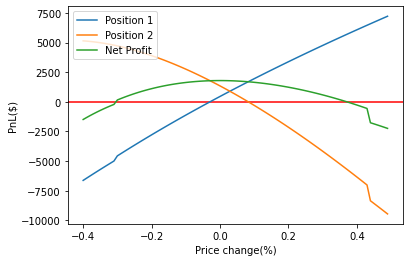

In [16]:
import matplotlib.pyplot as plt
import numpy as np
pnl = []
position1 = []
position2 = []
diff = []

for i in np.arange(-0.4, 0.5, 0.01):
    pnl.append(i)

    p1=profit_calc(2, 5000, 0, 1, i, 0, 3.0, 2.0, 0.4, 10, 0.8, 0.95)
    position1.append(p1)
    
    p2 = profit_calc(0, 5000, 30000, 1, i, 0, 3.0, 2.0, 0.4, 10, 0.8, 0.95)
    position2.append(p2)

    diff.append(p1+p2)

plt.axhline(y=0, color='r')
plt.plot(pnl, position1, label="Position 1")
plt.plot(pnl, position2, label="Position 2")
plt.plot(pnl, diff, label="Net Profit")
plt.legend(loc="upper left")
plt.xlabel("Price change(%)")
plt.ylabel("PnL($)")

### The area where green line is above the red line is the range of price movement one asset can experience while still generating positive profit for an investor. 

### It's worthnoting that position1 and position2 have different rate of change because of impermnant loss. Additionally, the sudden change of slope represents liquidation event.  

## Summary:
### This strategy is peudo delta neutral because it only generates profit when the prices of two underlying assets do not diverge significantly. In the example above, we used a 10-day investment horizon for WETH/USDC pair. Longer investment horizon will have wider profitable range of price movement. Rather than executing this strategy manually, there are many ways to improve its performance. I'll name a few that I'm currently exploring:
* Dynamically hedge your exposures by querying you position in the pool;
* Choose assets that have high correlations;
* Hedge your positions on CEXs using perpetual futures to capture funding interest while staying hedged. 
